In [ ]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Text length:', len(text))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Text length: 600893


In [ ]:
text[0:1000]

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, have been unskilled and unseemly methods for\nwinning a woman? certainly she has never allowed herself to be won; and\nat present every kind of dogma stands with sad and discouraged mien--if,\nindeed, it stands at all! for there are scoffers who maintain that it\nhas fallen, that all dogma lies on the ground--nay more, that it is at\nits last gasp. but to speak seriously, there are good grounds for hoping\nthat all dogmatizing in philosophy, whatever solemn, whatever conclusive\nand decided airs it has assumed, may have been only a noble puerilism\nand tyronism; and probably the time is at hand when it will be once\nand again understood what has actually sufficed for the basis of such\

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=True, filters='#$%&*+@/<=>^_')
tokenizer.fit_on_texts(text)

In [ ]:
seg_len = 60
stride = 3
segments = []
next_chars = []

for i in range(0, len(text) - seg_len, stride):
    segments.append(text[i: i + seg_len])
    next_chars.append(text[i + seg_len])

print('Number of segments:', len(segments))

Number of segments: 200278


In [ ]:
segments[0]

'preface\n\n\nsupposing that truth is a woman--what then? is the'

In [ ]:
segments[1]

'face\n\n\nsupposing that truth is a woman--what then? is there '

In [ ]:
from keras.preprocessing.sequence import pad_sequences

sequences_raw = tokenizer.texts_to_sequences(segments)
sequences = pad_sequences(sequences_raw, maxlen=seg_len)

print(sequences.shape)

(200278, 60)


In [ ]:
print(sequences[0, :])

[18  9  2 15  5 13  2 17 17 17  8 14 18 18  6  8  4  7 19  1  3 10  5  3
  1  3  9 14  3 10  1  4  8  1  5  1 21  6 16  5  7 25 25 21 10  5  3  1
  3 10  2  7 35  1  4  8  1  3 10  2]


In [ ]:
char_index = tokenizer.word_index
print(char_index)

{' ': 1, 'e': 2, 't': 3, 'i': 4, 'a': 5, 'o': 6, 'n': 7, 's': 8, 'r': 9, 'h': 10, 'l': 11, 'd': 12, 'c': 13, 'u': 14, 'f': 15, 'm': 16, '\n': 17, 'p': 18, 'g': 19, 'y': 20, 'w': 21, ',': 22, 'b': 23, 'v': 24, '-': 25, '.': 26, 'k': 27, '"': 28, 'x': 29, ':': 30, ';': 31, 'j': 32, 'q': 33, '!': 34, '?': 35, '(': 36, ')': 37, '1': 38, '=': 39, "'": 40, 'z': 41, '2': 42, '_': 43, '3': 44, '4': 45, '5': 46, '8': 47, '6': 48, '7': 49, '[': 50, ']': 51, '9': 52, '0': 53, 'ä': 54, 'æ': 55, 'é': 56, 'ë': 57}


In [ ]:
inv_char_index = {v: k for k, v in char_index.items()}
print(inv_char_index)

{1: ' ', 2: 'e', 3: 't', 4: 'i', 5: 'a', 6: 'o', 7: 'n', 8: 's', 9: 'r', 10: 'h', 11: 'l', 12: 'd', 13: 'c', 14: 'u', 15: 'f', 16: 'm', 17: '\n', 18: 'p', 19: 'g', 20: 'y', 21: 'w', 22: ',', 23: 'b', 24: 'v', 25: '-', 26: '.', 27: 'k', 28: '"', 29: 'x', 30: ':', 31: ';', 32: 'j', 33: 'q', 34: '!', 35: '?', 36: '(', 37: ')', 38: '1', 39: '=', 40: "'", 41: 'z', 42: '2', 43: '_', 44: '3', 45: '4', 46: '5', 47: '8', 48: '6', 49: '7', 50: '[', 51: ']', 52: '9', 53: '0', 54: 'ä', 55: 'æ', 56: 'é', 57: 'ë'}


In [ ]:
vocabulary = len(char_index)
seg_num = len(segments)

# one-hot encode
x = np.zeros((seg_num, seg_len, vocabulary), dtype=np.bool)
y = np.zeros((seg_num, vocabulary), dtype=np.bool)

for i, seg in enumerate(segments):
    y[i, char_index[next_chars[i]]-1] = 1
    for t, char in enumerate(seg):
        x[i, t, char_index[char]-1] = 1

In [ ]:
x.shape

(200278, 60, 57)

In [ ]:
y.shape

(200278, 57)

In [ ]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(seg_len, vocabulary)))
model.add(layers.Dense(vocabulary, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
model.fit(x, y, batch_size=128, epochs=15)

Epoch 1/15
200278/200278 [==============================] - 122s 610us/step - loss: 1.4462
Epoch 2/15
200278/200278 [==============================] - 116s 581us/step - loss: 1.4279
Epoch 3/15
200278/200278 [==============================] - 121s 606us/step - loss: 1.4139
Epoch 4/15
200278/200278 [==============================] - 124s 617us/step - loss: 1.4025
Epoch 5/15
200278/200278 [==============================] - 122s 608us/step - loss: 1.3930
Epoch 6/15
200278/200278 [==============================] - 123s 615us/step - loss: 1.3828
Epoch 7/15
200278/200278 [==============================] - 123s 616us/step - loss: 1.3737
Epoch 8/15
200278/200278 [==============================] - 125s 623us/step - loss: 1.3675
Epoch 9/15
200278/200278 [==============================] - 127s 635us/step - loss: 1.3616
Epoch 10/15
200278/200278 [==============================] - 125s 622us/step - loss: 1.3552
Epoch 11/15
200278/200278 [==============================] - 125s 623us/step - loss: 1.35

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def text_generation(model, x, segments, char_num, inv_char_index, temperature, rand_index):
    _, seg_len, vocabulary = x.shape
    x_input = x[rand_index, :, :].reshape((1, seg_len, vocabulary))
    text = segments[rand_index]
    for i in range(char_num):
        pred = model.predict(x_input, verbose=0)[0]
        next_index = sample(pred, temperature)
        next_char = inv_char_index[next_index+1]
        text += next_char
        x_input[0, 0:seg_len-1, :] = x_input[0, 1:seg_len, :]
        x_input[0, seg_len-1, :] = 0
        x_input[0, seg_len-1, next_index] = 1
    return text

In [ ]:
#rand_index = np.random.randint(0, seg_num)
generated_text = text_generation(model, x, segments, 400,
                                 inv_char_index, 0.5, rand_index)
print(generated_text)

mmediately disclose what it really is--namely, a will
to the the believest constive the art of the persision the says of a gan himself need not religion a consting be naturing and suld the pretendents as the constion. the are the good teach that the most and find of endent and the self it of instinct a mean constition of can the constive in this sour from the bad and all the philosophy to condividuation men and the goence the condines the all as most strat


In [ ]:
generated_text = text_generation(model, x, segments, 400,
                                 inv_char_index, 0.5, rand_index)
print(generated_text)

mmediately disclose what it really is--namely, a will
to thecience of the original he who has not in the truth of the point, has not words from the devilished and sensible and discerence to the far an morals: the desire to a such as to the sexual of the morality and their world and with an ought of the morally and self-possession of the presumptance, of philosophy the sense of the conduct of the and oppression that a man of a delicate and can be a man of h


In [ ]:
np.random.multinomial(1, [0.1, 0.5, 0.2, 0.2], 1)

array([[0, 0, 1, 0]])

In [ ]:
prob = np.array([0.1, 0.5, 0.2, 0.2])
prob = prob ** 0.5

In [ ]:
prob / np.sum(prob)

array([0.16489419, 0.36871462, 0.2331956 , 0.2331956 ])

In [ ]:
import numpy as np

p = np.abs(np.random.randn(28))
p /= np.sum(p)


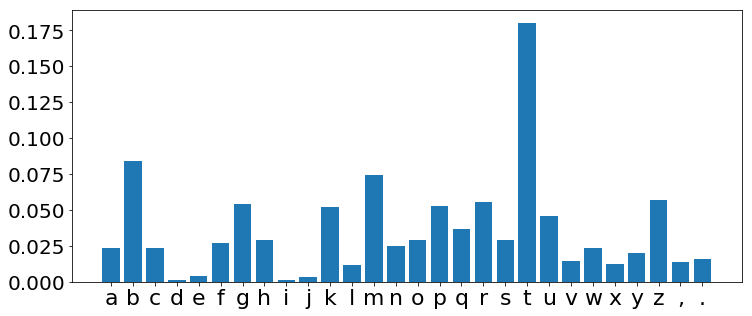

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

xticks = 'abcdefghijklmnopqrstuvwxyz,.'
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(np.arange(len(xticks)), p, tick_label=xticks)
ax.set_xticklabels(xticks, fontsize=22)
plt.yticks(fontsize=20)
plt.show()
fig.savefig('text_pred.pdf', format='pdf', dpi=1200)

TypeError: must be str, not int

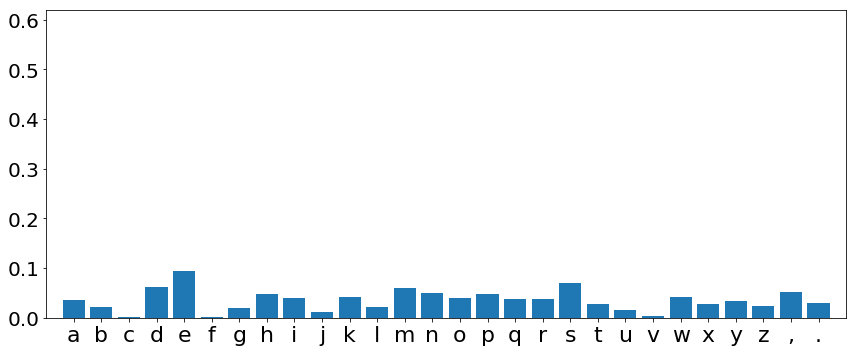

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xticks = 'abcdefghijklmnopqrstuvwxyz,.'
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(np.arange(len(xticks)), p, tick_label=xticks)
ax.set_xticklabels(xticks, fontsize=22)
plt.yticks(fontsize=20)
plt.axis([-1, 28, 0, 0.62])
plt.tight_layout()
plt.show()
fig.savefig('prob1.pdf', format='pdf', dpi=1200)

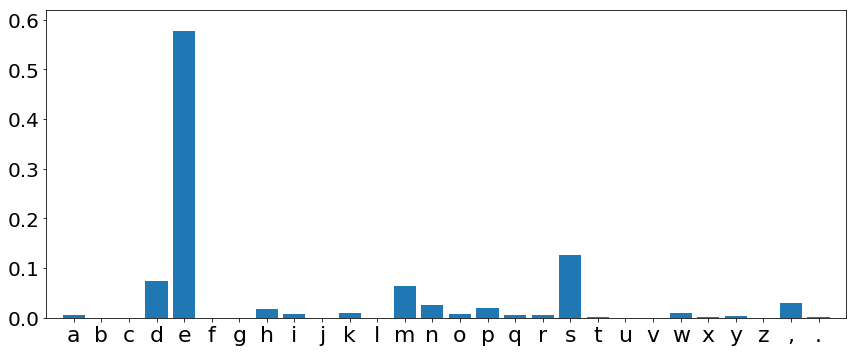

In [ ]:
temperature = 0.2

pred = p ** (1 / temperature)
pred = pred / np.sum(pred)


xticks = 'abcdefghijklmnopqrstuvwxyz,.'
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(np.arange(len(xticks)), pred, tick_label=xticks)
ax.set_xticklabels(xticks, fontsize=22)
plt.yticks(fontsize=20)
plt.axis([-1, 28, 0, 0.62])
plt.tight_layout()

plt.show()
fig.savefig('prob3.pdf', format='pdf', dpi=1200)